# **Intel Image Classification**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os

## Importing Data

In [10]:
file_path = r'C:\Users\Matúš\.jupyter\csv\intel_cls'

In [116]:
train_path = os.path.join(file_path, 'seg_train\seg_train')
test_path = os.path.join(file_path, 'seg_test\seg_test')
pred_path = os.path.join(file_path, 'seg_pred')

In [168]:
cls_names = os.listdir(train_path)
n_classes = len(os.listdir(train_path))

In [257]:
images_in_each_class = []
for cls in os.listdir(train_path):
    images_in_each_class.append(len(os.listdir(os.path.join(train_path, cls))))

In [258]:
n_train_images = np.sum(images_in_each_class)

## Analyzing Data

In [272]:
for cls in os.listdir(train_path):
    n_images = len(os.listdir(os.path.join(train_path, cls)))
    print(f'{cls}:    \t {n_images} \t {100*(n_images / n_train_images):.2f}%')

buildings:    	 2191 	 15.61%
forest:    	 2271 	 16.18%
glacier:    	 2404 	 17.13%
mountain:    	 2512 	 17.90%
sea:    	 2274 	 16.20%
street:    	 2382 	 16.97%


buildings


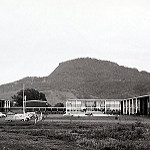


forest


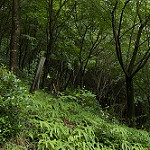


glacier


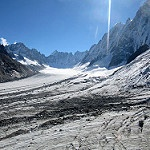


mountain


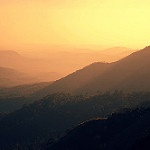


sea


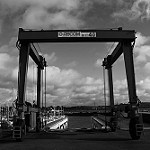


street


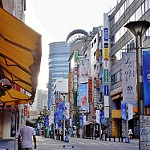

In [321]:
from IPython.display import Image



for idx, cls in enumerate(os.listdir(train_path)):
    sample = os.listdir(os.path.join(train_path, cls))[0]  # First image from each class
    print(cls)
    display(Image(filename=os.path.join(train_path, cls, sample)))
    print()

In [346]:
import PIL.Image
from collections import Counter

def sizes_of_images(directory):
    
    sizes = Counter()
    
#     sizes = []
    for cls in os.listdir(directory):
        for i in range(len(os.listdir(os.path.join(directory, cls)))):
            sample = os.listdir(os.path.join(directory, cls))[i]
            sizes.update([PIL.Image.open(os.path.join(directory, cls, sample)).size])

    return sizes

In [347]:
images_sizes = sizes_of_images(train_path)  # return unique sizes of images from training images

In [348]:
images_sizes.most_common(5)

[((150, 150), 13986),
 ((150, 113), 7),
 ((150, 135), 3),
 ((150, 111), 3),
 ((150, 108), 2)]

As we can see almost all images have shape 150x150, hence we will preprocessed images with differnt shape to the shape of 150x150 using the ImageDataGenerator

## Preparing Data

In [60]:
# Data Augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                             rotation_range=20,
                                                             horizontal_flip=True,
                                                             width_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(train_path, 
                                                   batch_size=32, 
                                                   target_size=(150, 150),
                                                   class_mode="categorical",
                                                   shuffle=True,
                                                   seed=42)

Found 14034 images belonging to 6 classes.


In [76]:
test_datagen = keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_path, 
                                                  batch_size=32, 
                                                  target_size=(150, 150),
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=42)

Found 3000 images belonging to 6 classes.


## Creating a Model

In [103]:
model = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=train_generator.image_shape),
    keras.layers.Conv2D(64, kernel_size=(5, 5), strides=2, activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax')
])

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 73, 73, 64)        4864      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 128)        

In [109]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [110]:
model.fit(train_generator, epochs=10,
          callbacks=[keras.callbacks.EarlyStopping(patience=2)],
          validation_data=test_generator)

Epoch 1/10
439/439 [==============================] - 191s 435ms/step - loss: 0.9695 - accuracy: 0.6293 - val_loss: 0.8293 - val_accuracy: 0.7163
Epoch 2/10
439/439 [==============================] - 210s 477ms/step - loss: 0.7168 - accuracy: 0.7438 - val_loss: 0.6345 - val_accuracy: 0.7823
Epoch 3/10
439/439 [==============================] - 210s 479ms/step - loss: 0.6355 - accuracy: 0.7732 - val_loss: 0.6073 - val_accuracy: 0.7857
Epoch 4/10
439/439 [==============================] - 197s 450ms/step - loss: 0.5852 - accuracy: 0.7904 - val_loss: 0.5132 - val_accuracy: 0.8237
Epoch 5/10
439/439 [==============================] - 200s 455ms/step - loss: 0.5519 - accuracy: 0.8001 - val_loss: 0.5203 - val_accuracy: 0.8173
Epoch 6/10
439/439 [==============================] - 199s 453ms/step - loss: 0.5170 - accuracy: 0.8111 - val_loss: 0.5476 - val_accuracy: 0.8157


## Predicting

In [134]:
pred_datagen = keras.preprocessing.image.ImageDataGenerator()
pred_generator = pred_datagen.flow_from_directory(pred_path, 
                                                  batch_size=1, 
                                                  target_size=(150, 150),
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 7301 images belonging to 1 classes.


In [250]:
def plot_predictions(model, data_generator, cls_names, n_rows=5, n_cols=5, figsize=(16, 16)):
    
    plt.figure(figsize=figsize)

    predictions = model.predict(data_generator)
    cls_predictions = np.argmax(predictions, axis=1)

    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        plt.axis('off')
        
        name_of_prediction = cls_names[cls_predictions[i]]
        probabilities = predictions.max(axis=1)[i]
        
        plt.title(f'{name_of_prediction} - {(100*probabilities):.2f}%', fontsize=14)
        plt.tight_layout()
        plt.imshow(pred_generator[i][0] / 255);

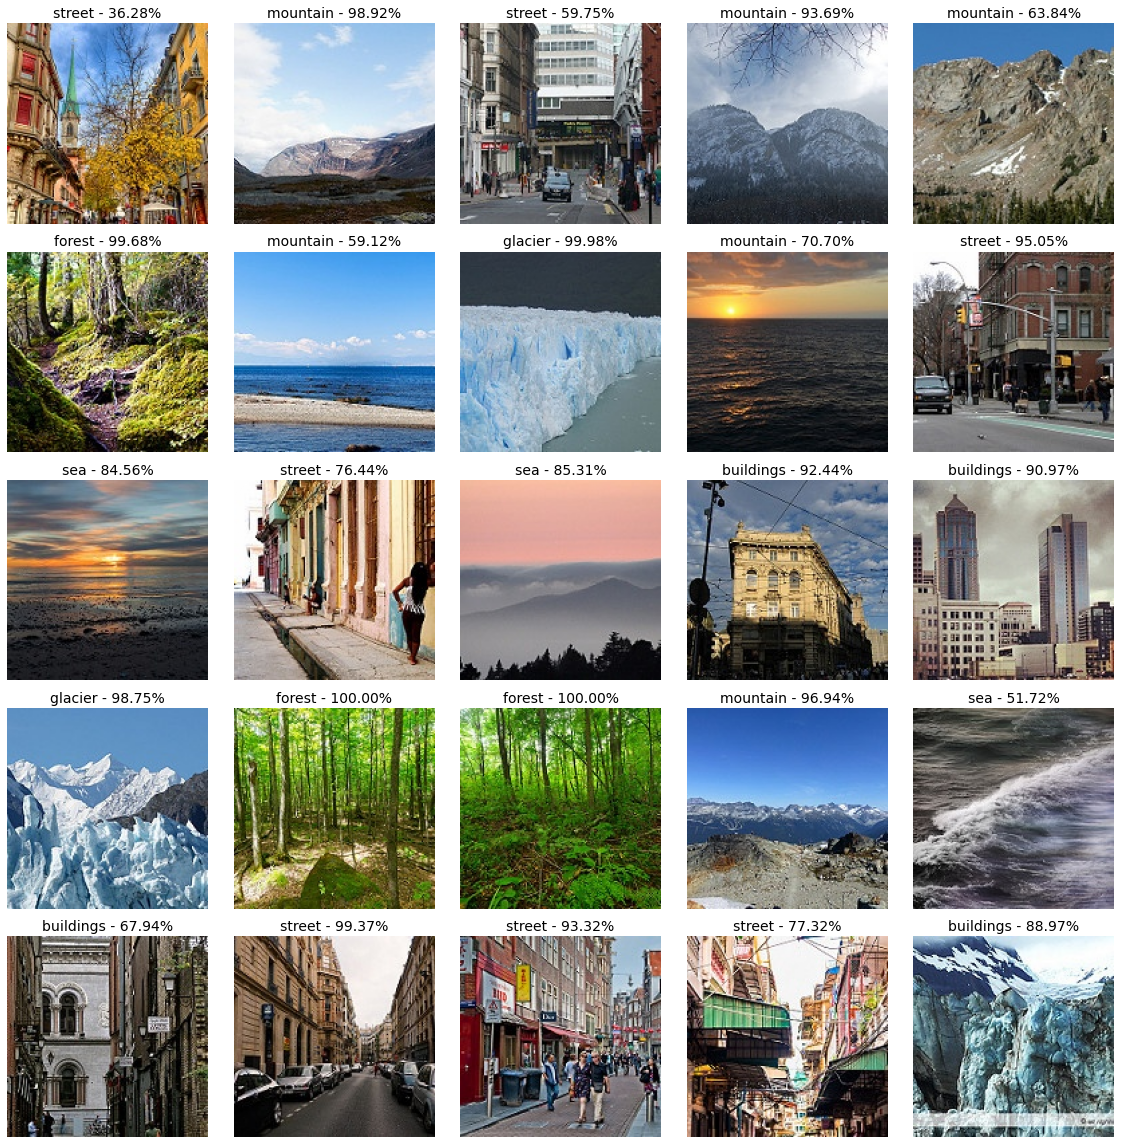

In [251]:
plot_predictions(model, pred_generator, cls_names)

****

In [359]:
model.save(r'C:\Users\Matúš\.jupyter\models\intel.h5')
model.save_weights(r'C:\Users\Matúš\.jupyter\models\intel_weights.h5')

In [356]:
# loaded_model = keras.models.load_model(r'C:\Users\Matúš\.jupyter\models\intel.h5')